# Task A: Evasion Attacks and Mitigation

## A Reference CNN for Image Classification using Fashion-MNIST data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.saving import load_model

In [2]:
# Load Fashion-MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

num_classes = 10
class_names = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print("Train subset:", x_train.shape, "Test:", x_test.shape)


Train subset: (60000, 28, 28, 1) Test: (10000, 28, 28, 1)


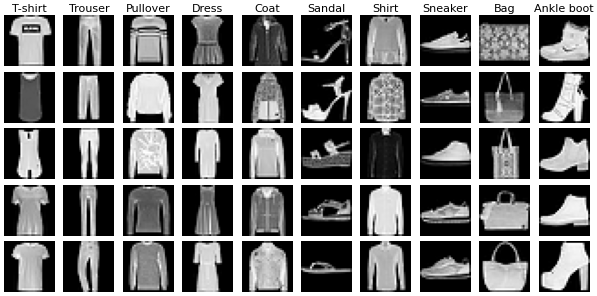

In [3]:
# Visualize 5 samples for each class

samples_per_class = 5
num_classes = 10

plt.figure(figsize=(num_classes * 1.5, samples_per_class * 1.5), dpi=40)

for cls in range(num_classes):
    # Pick 5 samples from this class
    idxs = np.where(y_train == cls)[0][:samples_per_class]

    for row, idx in enumerate(idxs):
        ax = plt.subplot(samples_per_class, num_classes, row * num_classes + cls + 1)
        plt.imshow(x_train[idx].squeeze(), cmap="gray")
        plt.axis("off")
        
        # Add class label to the top row only
        if row == 0:
            ax.set_title(class_names[cls], fontsize=20)

plt.tight_layout()
plt.show()

In [4]:
def make_fmnist_cnn():
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, (3, 3), activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = make_fmnist_cnn()
model.summary()

# Make sure the we don't rerun the trainning
if os.path.exists("fminist_convnet.keras"):
    model = load_model("fminist_convnet.keras")
else:
    callback = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
    )
    model.fit(
        x_train,
        y_train,
        validation_split=0.1,
        epochs=15,
        batch_size=64,
        callbacks=[callback],
        verbose=2,
    )
    model.save("fminist_convnet.keras")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Clean test accuracy:", test_acc)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Clean test accuracy: 0.9146999716758728


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


<Figure size 4000x3200 with 0 Axes>

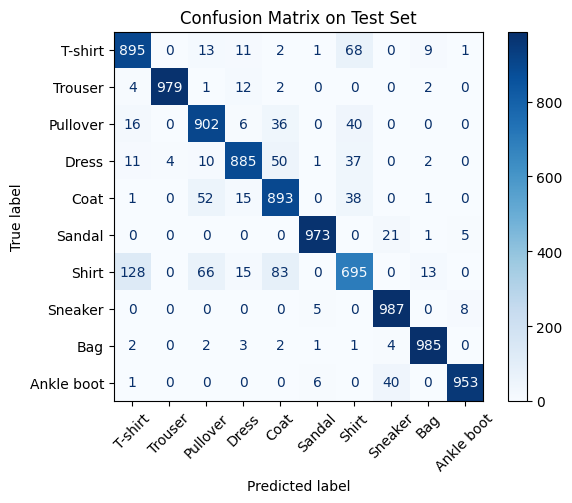

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the entire test set
y_pred_test = np.argmax(model.predict(x_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(20, 16), dpi=200)
disp.plot(cmap="Blues", xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()

## Task A.1. Fast Gradient Sign Method (FGSM) [20 points]

See the documentation: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm

In [6]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod

In [7]:
classifier = KerasClassifier(
    model=model,
    clip_values=(0.0, 1.0),
)

### Implement A.1.1 below [10 points]

In [8]:
#...

### Implement A.1.2 below [10 points]

In [9]:
#...

## Task A.2. Projected Gradient Descent (PGD) [20 points]

See the documentation: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#projected-gradient-descent-pgd

In [10]:
from art.attacks.evasion import ProjectedGradientDescent

### Implement A.2.1 below [10 points]

In [11]:
#...

### Implement A.2.2 below [10 points]

In [12]:
#...

## Task A.3. Mitigation via JPEG Compression [20 points]

See the documentation: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/preprocessor.html#jpeg-compression

In [13]:
from art.defences.preprocessor import JpegCompression

### Implement A.3.1 below [10 points]

In [14]:
#...

### Implement A.3.2 below [10 points]

In [15]:
#...